# Using Unsupervised Learning to plan Paris Vacation - clustering

In [14]:
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

try:
    import contextily as cx
except ImportError as error:
    !pip install contextily==1.2.0;
    import contextily as cx


import rasterio # installed by contextily
from rasterio.plot import show as rioshow

import geopandas

!pip install haversine
import haversine as hs

from sklearn.cluster import BisectingKMeans # Importing KMeans

import folium

try:
    import networkx as nx
except ImportError as error:
    !pip install networkx;
    import networkx as nx
import networkx.algorithms.approximation as nx_app

sns.set_theme()

In [15]:
df_coord = pd.read_csv('../raw_data/poi.csv')

df_coord

,id,name,latitude,longitude,street,zipcode,locality
0,4636128,La Maison de Chateaubriand,48.773223,2.266922,87 rue Chateaubriand,92290.0,Châtenay-Malabry
1,685108,La Bellevilloise,48.868720,2.392044,19-21 rue Boyer,75020.0,Paris
2,5734034,Reality Game,48.935398,1.736152,NaN,78930.0,Guerville
3,5829137,Ô Café Gourmand,48.965689,1.897926,1 Rue Maurice Berteaux,78410.0,Bouafle
4,4825511,Le Mandarin Rouge (l'Orient Rouge),48.694065,1.853712,"6, rue de Chartres",78610.0,Le Perray-en-Yvelines
...,...,...,...,...,...,...,...
5621,731002,Campanile Saint-Germain-lès-Corbeil,48.630053,2.493583,NaN,NaN,NaN
5622,780402,Salon Saveurs des plaisirs gourmands,48.887514,2.288562,NaN,NaN,NaN
5623,701025,Espace Lumière,48.954663,2.313941,NaN,NaN,NaN
5624,731021,Hôtel Ibis Evry-Courcouronnes,48.619821,2.420781,NaN,NaN,NaN


## Premières visualisations
### Répartition géographique


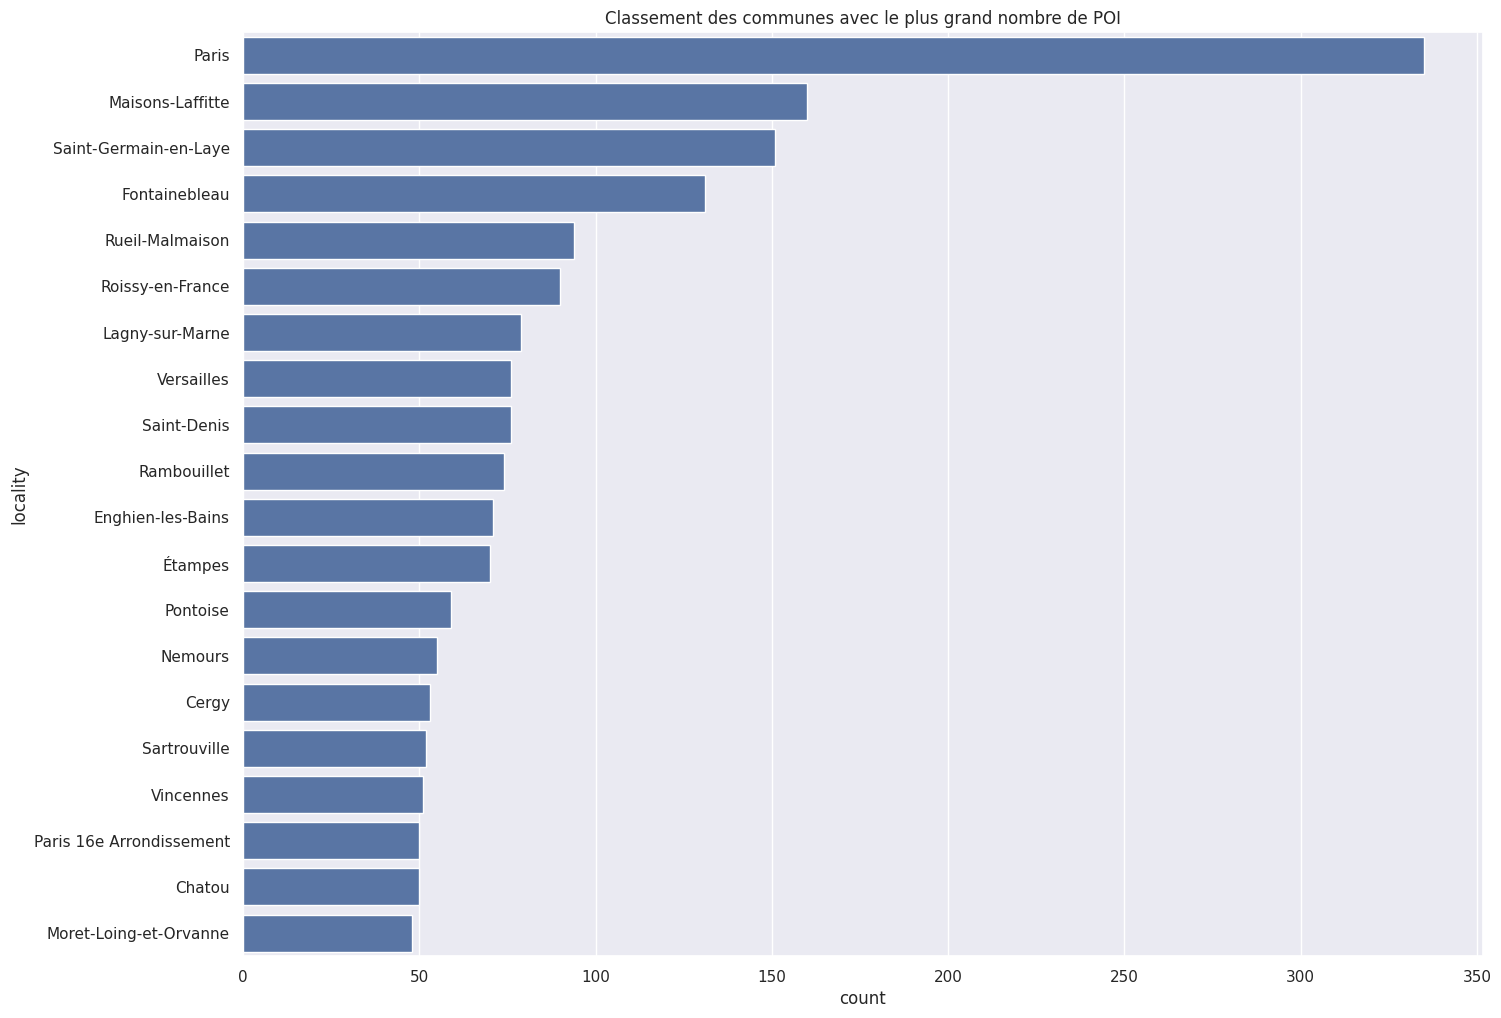

In [16]:
#Confirmation de l'emplacement des POI par commune

sns.set(rc = {'figure.figsize':(16,12)})
sns.countplot(y="locality", color = "b", data = df_coord, order=df_coord.locality.value_counts().iloc[:20].index).set_title('Classement des communes avec le plus grand nombre de POI');

# On choisit les 20 premières communes pour améliorer la lisibilité du graphique
# Les communes avec le plus grand nombre de POI sont bien situées sur la côte, en tête Saint-Malo avec une large longueur d'avanc
# Il va être intéressant par la suite de s'intéresser au détail de ces POI

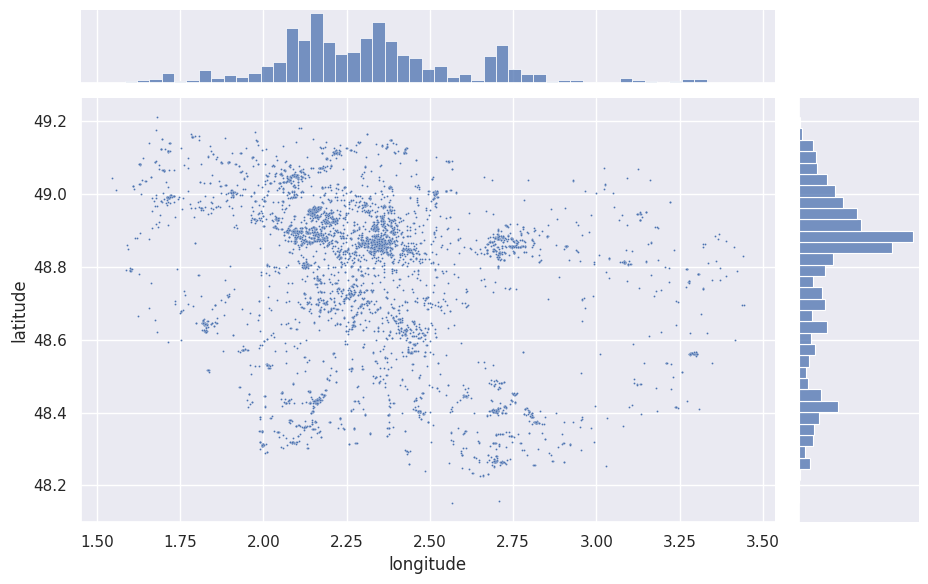

In [17]:
#Répartition des POI en fonction de la latitude et longitude

sns.jointplot(x='longitude', y='latitude', data=df_coord, s=2 ).fig.set_figwidth(10)

# On adapte la taille du jointplot en rectangle pour retrouver +/- la forme de la Bretagne
# On observe par la même occasion qu'il n'y a pas de valeur aberrante, tous les points sont localisés dans une zone géographique cohérente
# On remarque à première vue que la plupart des lieux sont à Paris intra-muros.
# On devine la forme de l'ile de france avec une très forte concentration


## Modélisation

### Choix utilisateurs


In [19]:
u_start_point = (48.8672391, 2.3210898) # Hotel Crillon place de la Concorde
u_nb_jour = 7
u_moyen_mobilite = "Velo" # Marche/ Velo / Voiture
u_categorie = None
u_nb_pts_max = 48 # temps min de visite 30 minutes = 24H par jour


### Constantes

In [20]:
#Definition des paramètres d'itinéraires
MAX_TIME_PER_DAY = 480 #8h * 60 min

MAX_KM_BY_TRANSPORT = {
    "Marche": 5, #10 km Aller / Retour
    "Velo": 10, #20 km Aller / Retour
    "Metro": 15 #30 km Aller / Retour
}

# Gestion de la distance max
nb_km_max = MAX_KM_BY_TRANSPORT[u_moyen_mobilite]

# Couleurs utilisées par folium pour les markers
FOLIUM_COLORS = [
    'red','blue', 'green', 'purple', 'orange', 'darkred',
    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
    'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'
]
# Zoom a appliquer sur la carte
ZOOM_LVL = {
    'Metro': 9,
    'Velo': 11,
    'Marche': 20
}

## Fonctions


In [25]:
# Declaration des fonction
def plot_markers(dataframe, map_to_plot, color_palette = FOLIUM_COLORS, icon='star'):
    """
        Plot markers on a foilum map using coord column on a dataframe and a specified color palette
    """
    for _idx, row in dataframe.iterrows():
        color_idx = row["Jour"] - 1
        max_colors_idx = len(color_palette) - 1
        if color_idx > max_colors_idx:
            color_idx = color_idx - max_colors_idx
        color = color_palette[color_idx]
        icon_color = 'dimgray' if color == 'white' else 'white'
        folium.Marker(
            location= list(row.Coord),
            popup= f"<h5>Jour {row['Jour']}</h5><p>{row['name']}</p>",
            icon= folium.Icon(color= color, icon_color= icon_color, icon=icon)
        ).add_to(map_to_plot)

def plot_day_path(dataframe, map_to_plot, color):
    """
        Compute shortest path by creating a graph from coordonates and then plot it on a folium map in. the selected color
    """
    G = nx.Graph()
    nodes = np.arange(0, len(dataframe))
    # nodes -> array([0, 1, 2, 3, 4])
    G.add_nodes_from(nodes)

    for i in nodes:
        for j in nodes:
            if i!=j:
                G.add_edge(i, j)

    #Create a dictionary of node and coordinate of each state for positions
    positions = {node:coordinate for node, coordinate in zip(nodes, dataframe.Coord)}

    #Create a dictionary of node and capital for labels
    labels = {node:name for node, name in zip(nodes, dataframe['name'])}

    cycle = nx_app.christofides(G, weight="weight")

    folium_coordinates = []
    for lat,lon in dataframe.Coord:
        folium_coordinates.append([lat,lon])

    route = [] # u_start_point
    for stop in cycle:
        route.append(folium_coordinates[stop])
    folium.PolyLine(route, color = color, weigth = 0.5).add_to(map_to_plot)

def result_df(result):
    return pd.DataFrame(result['Jour'].value_counts().sort_index()).rename(columns= {'Jour': 'nombre POI'})


### Application des paramètres utilisateurs à l'ensemble de points


In [26]:
def get_user_radius_df():
    app_df = df_coord.copy()

    #Ensemble des coordonnées
    app_df["Coord"] = list(zip(app_df["latitude"], app_df["longitude"])) # Coord tupples

    # Calcul de la distance au point de départ
    app_df["Distance_start_point"] = app_df["Coord"].apply(lambda point: hs.haversine(u_start_point, point))

    # Conservation des points dans le rayon du point de départ du voyageur
    return app_df[app_df["Distance_start_point"] <= nb_km_max].copy()


# NOTE: https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html#GeoSeries.buffer
# aurait pu etre une option


### Carte points par jour


In [27]:
### KMeans solo
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=u_nb_jour, random_state=123)
kmean_places_to_visit = get_user_radius_df()

X = kmean_places_to_visit[['latitude','longitude']].values
predictions = kmeans_1.fit_predict(X)
clustered = pd.concat([kmean_places_to_visit.reset_index(),
                       pd.DataFrame({'Cluster':predictions})],
                      axis=1)

clustered["Jour"] = clustered["Cluster"] + 1

kmeans_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])

plot_markers(clustered, map_to_plot=kmeans_map)

kmeans_map

/home/david/anaconda3/envs/itineraire-touristique/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/david/anaconda3/envs/itineraire-touristique/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


distances[knee] :2.509711068216532
knee: 163
0.0003939267935427325


<Figure size 500x500 with 0 Axes>

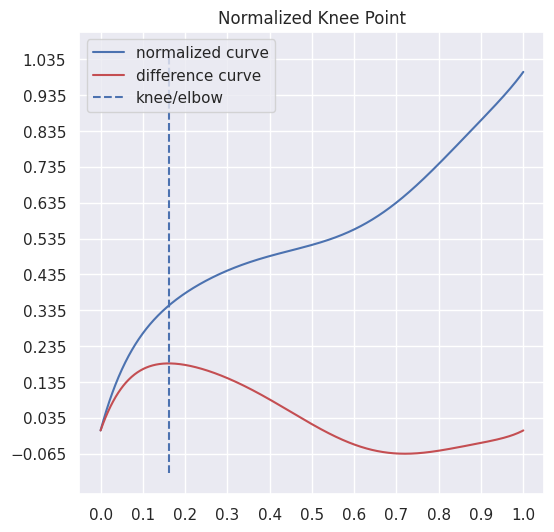

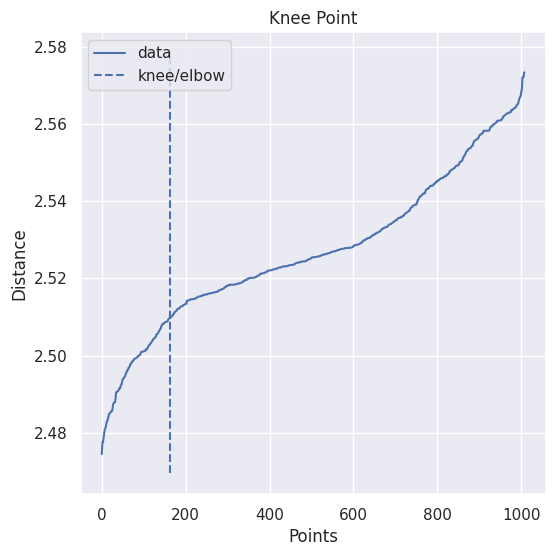

In [31]:
#### DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

try:
    from kneed import KneeLocator
except ImportError as error:
    !pip install kneed[plot];
    from kneed import KneeLocator

# WIP
# Since we’re talking in radians now, we need to convert the epsilon input into radian measure.
# See:
# - https://towardsdatascience.com/lets-do-spatial-clustering-with-dbscan-c3dbfd9fc4d2
# - https://stats.stackexchange.com/questions/218530/applying-dbscan-to-a-huge-gis-dataset-with-a-haversine-distance-metric
# - https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers
KMS_PER_RADIAN = 6371.0088

dbscan_places_to_visit = get_user_radius_df()

nearest_neighbors = NearestNeighbors(n_neighbors = u_nb_jour, metric ="haversine") # 5 parce que pourquoi pas ?

radians_coords = np.radians([x for x in zip(dbscan_places_to_visit["latitude"], dbscan_places_to_visit["longitude"])])
neighbors = nearest_neighbors.fit(radians_coords)
distances, indices = neighbors.kneighbors(dbscan_places_to_visit[["latitude", "longitude"]])
distances = np.sort(distances[:,3], axis=0)
# Find the elbow / knee
i = np.arange(len(distances))
kneedle = KneeLocator(
    i,
    distances,
    S=1,
    curve='concave',
    online=True,
    direction='increasing',
    interp_method='polynomial',
    polynomial_degree=7
)

PLOT_KNEE = True

if PLOT_KNEE:
    fig = plt.figure(figsize=(5, 5))
    kneedle.plot_knee_normalized()
    kneedle.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    print(f"distances[knee] :{distances[kneedle.knee]}")

print(f"knee: {kneedle.knee}")

eps = distances[kneedle.knee]

def haversine_dbscan(epsilon, min_samples, latitudes, longitudes):
    epsilon_for_haversine = epsilon / KMS_PER_RADIAN
    print(epsilon_for_haversine)

    # The ball tree algorithm is used to speed up the algorithm run time

    # The haversine calculation requires co-ordinate pairs to be specified in radians and not degrees.
    # We do this via a quick call to one of my favourite packages — numpy . We need to make sure that the order
    # of the co-ordinate pairs is correct, as sklearn expects latitude first.
    # (PLUS HAUT)
    # app_df["coord"] = list(zip(app_df["Latitude"], app_df["Longitude"])) # Coord tupples

    dbscan = DBSCAN(
        eps = epsilon_for_haversine,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine'
    )


    dbscan.fit(np.radians([x for x in zip(latitudes,longitudes)]))

    return dbscan.labels_

labels = haversine_dbscan(
    epsilon=eps,
    min_samples=2,
    latitudes=dbscan_places_to_visit['latitude'],
    longitudes=dbscan_places_to_visit["longitude"]
)

dbscan_places_to_visit['Cluster'] = labels
dbscan_places_to_visit = dbscan_places_to_visit[dbscan_places_to_visit['Cluster'] != -1] # remove outliers
dbscan_places_to_visit['Jour'] = dbscan_places_to_visit['Cluster'] + 1

dbscan_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])

plot_markers(dbscan_places_to_visit, map_to_plot=dbscan_map)

dbscan_map

In [32]:
try:
    import hdbscan
except ImportError as error:
    !pip install hdbscan;
    import hdbscan

hdbscan_places_to_visit = get_user_radius_df()

radians_coords = np.radians(hdbscan_places_to_visit[['latitude', 'longitude']].values) # ¯\_( ͡° ͜ʖ ͡°)_/¯

hdbscan_clf = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine')
predictions = hdbscan_clf.fit_predict(radians_coords)

hdbscan_clustered = pd.concat([hdbscan_places_to_visit.reset_index(),  pd.DataFrame({'Cluster':predictions})],  axis=1)
hdbscan_clustered = hdbscan_clustered[hdbscan_clustered['Cluster'] != -1]
hdbscan_clustered['Jour'] = hdbscan_clustered['Cluster'] + 1

hdbscan_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])

plot_markers(hdbscan_clustered, map_to_plot=hdbscan_map)

hdbscan_map

IndexError: list index out of range